# Feature Engineering with open source

In this notebook we reproduce feature engineering pipeline from notebook 2 using [scikit learn](https://scikit-learn.org/) and [feature engine](https://feature-engine.readthedocs.io/en/1.2.x/)

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# saving pipeline
import joblib

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

# feature-engine
from feature_engine.imputation import(
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder
)

from feature_engine.transformation import (
    LogTransformer,
    YeoJohnsonTransformer
)


from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper


pd.pandas.set_option('display.max_columns', None)

In [132]:
data = pd.read_csv('train.csv')

print(data.shape)

data.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Separate dataset into train and test set

Some feature engineering technique will require learning from our data. For this purpose it is important we learn from our train data (not both) to avoid overfitting

- mean
- mode
- exponent for yeo-johnson
- category frequency
- and category to number mappings


**Separating the data into train and test involves randomness, therefore, we need to set the seed.**

In [133]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['Id', 'SalePrice'], axis=1), #predictor
    data['SalePrice'], #target
    test_size=0.1, # 10% for testing
    random_state=0 # seed -> for reproduceability
)


X_train.shape, X_test.shape

((1314, 79), (146, 79))

# Feature Engineering

We will carry out feature engineering in to take care of the following

1. Missing values
2. Temporal variables
3. Non-Gaussian distributed variables
4. Categorical variables: remove rare labels
5. Categorical variables: convert strings to numbers
5. Standardize the values of the variables to the same range

In [134]:
y_train = np.log(y_train)
y_test = np.log(y_test)

## Missing values
### Categorical Variables

In [135]:
cat_vars = [var for var in data.columns if data[var].dtype == 'O']

cat_vars = cat_vars + ['MSSubClass']


X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')


len(cat_vars)

44

In [136]:
cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]


X_train[cat_vars_with_na].isnull().mean().sort_values(
    ascending=False
)

PoolQC          0.995434
MiscFeature     0.961187
Alley           0.938356
Fence           0.814307
FireplaceQu     0.472603
GarageType      0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
BsmtExposure    0.025114
BsmtFinType2    0.025114
BsmtQual        0.024353
BsmtCond        0.024353
BsmtFinType1    0.024353
MasVnrType      0.004566
Electrical      0.000761
dtype: float64

In [137]:
# for columns with missing value greater than 10%
# replace with 'missing'
# While for those less than 10% replace with the first mode


with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean()
    > 0.1 
]


with_mode_missing = [
    var for var in cat_vars_with_na if X_train[var].isnull().mean()
    < 0.1
]

In [138]:
with_string_missing

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [139]:
# replace missing value with label: "missing"

cat_imputer_missing = CategoricalImputer(
    imputation_method='missing', variables=with_string_missing
)

cat_imputer_missing.fit(X_train)

cat_imputer_missing.imputer_dict_

{'Alley': 'Missing',
 'FireplaceQu': 'Missing',
 'PoolQC': 'Missing',
 'Fence': 'Missing',
 'MiscFeature': 'Missing'}

In [140]:
# replace NA with missing

X_train = cat_imputer_missing.transform(X_train)
X_test = cat_imputer_missing.transform(X_test)



In [141]:
cat_imputer_mode = CategoricalImputer(
    imputation_method='frequent', variables=with_mode_missing
)

cat_imputer_mode.fit(X_train)

cat_imputer_mode.imputer_dict_

{'MasVnrType': 'None',
 'BsmtQual': 'TA',
 'BsmtCond': 'TA',
 'BsmtExposure': 'No',
 'BsmtFinType1': 'Unf',
 'BsmtFinType2': 'Unf',
 'Electrical': 'SBrkr',
 'GarageType': 'Attchd',
 'GarageFinish': 'Unf',
 'GarageQual': 'TA',
 'GarageCond': 'TA'}

In [142]:
X_train = cat_imputer_mode.transform(X_train)
X_test = cat_imputer_mode.transform(X_test)

In [143]:
X_train[cat_vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [144]:
[
    var for var in cat_vars_with_na if X_test[var].isnull().sum()
]

[]

## Numerical variables

For numerical variable we will

- add a binary indicator column
- replace the missing va;ue in the original variable with the meaN

In [145]:
num_vars = [
    var for var in X_train.columns if var not in cat_vars
]

len(num_vars)

35

In [146]:
var_with_na = [
    var for var in num_vars if X_train[var].isnull().sum() > 0
]


X_train[var_with_na].isnull().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
GarageYrBlt    0.056317
dtype: float64

In [147]:
var_with_na

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [148]:
missing_ind = AddMissingIndicator(variables=var_with_na)

missing_ind_var = missing_ind.fit(X_train)



In [149]:
missing_ind_var.variables_

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [150]:
X_train = missing_ind.transform(X_train)
X_test = missing_ind.transform(X_test)

X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head(4)

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
930,0,0,0
656,0,0,0
45,0,0,0
1348,1,0,0


In [151]:
mean_imputer = MeanMedianImputer(
    imputation_method='mean', variables=var_with_na
)

mean_imputer.fit(X_train)

mean_imputer.imputer_dict_

{'LotFrontage': 69.87974098057354,
 'MasVnrArea': 103.7974006116208,
 'GarageYrBlt': 1978.2959677419356}

In [152]:
X_train = mean_imputer.transform(X_train)
X_test = mean_imputer.transform(X_test)


X_train[var_with_na].isnull().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

## Temporal Variable

In [153]:
def elapsed_years(df, var):

    df[var] = df['YrSold'] - df[var]
    return df

In [154]:
for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:

    X_train = elapsed_years(X_train, var)
    X_test = elapsed_years(X_test, var)

In [155]:
drop_features = DropFeatures(features_to_drop=['YrSold'])


X_train = drop_features.fit_transform(X_train)
X_test = drop_features.fit_transform(X_test)

## Numerical variable transformation

### Logarithmic transformation

In [156]:
log_transformer = LogTransformer(
    variables=["LotFrontage", "1stFlrSF", "GrLivArea"]
)

X_train = log_transformer.fit_transform(X_train)
X_test = log_transformer.fit_transform(X_test)




In [157]:
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] 

    if X_train[var].isnull().sum() > 0]

[]

In [158]:
[var for var in ["LotFrontage", "1stFlrSF", "GrLivArea"] 

    if X_test[var].isnull().sum() > 0]

[]

### Yeo-Johnson transformation

In [159]:
yeo_transformer = YeoJohnsonTransformer(
    variables=['LotArea']
)

X_train = yeo_transformer.fit_transform(X_train)
X_test = yeo_transformer.transform(X_test)

yeo_transformer.lambda_dict_

/home/arnold/Desktop/MlOp/env/lib/python3.8/site-packages/scipy/stats/morestats.py:1557: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(trans.var(axis=0))
/home/arnold/Desktop/MlOp/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:2621: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom
/home/arnold/Desktop/MlOp/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:2214: RuntimeWarning: invalid value encountered in double_scalars
  tmp1 = (x - w) * (fx - fv)
/home/arnold/Desktop/MlOp/env/lib/python3.8/site-packages/scipy/optimize/optimize.py:2215: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


{'LotArea': -12.55283001172003}

In [160]:
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [161]:
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

### Binarize skewed variables

In [162]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

binarizer = SklearnTransformerWrapper(
    transformer=Binarizer(threshold=0), variables=skewed
)


X_train = binarizer.fit_transform(X_train)
X_test = binarizer.fit_transform(X_test)

X_train[skewed].head()

,BsmtFinSF2,LowQualFinSF,EnclosedPorch,3SsnPorch,ScreenPorch,MiscVal
930,0,0,0,0,0,0
656,0,0,0,0,0,0
45,0,0,0,0,0,0
1348,0,0,0,0,0,0
55,0,0,0,1,0,0


## Categorical variables

### Applied mapplings



In [163]:
qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]
            
for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_test[var] = X_test[var].map(qual_mappings)

In [164]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'


X_train[var] = X_train[var].map(exposure_mappings)
X_test[var] = X_test[var].map(exposure_mappings)

In [165]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']


for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)


In [166]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'


X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)

In [167]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

In [168]:
[
    var for var in X_train.columns if X_train[var].isnull().sum() > 0
]

[]

In [169]:

[
    var for var in X_test.columns if X_test[var].isnull().sum() > 0
]

[]

### Removing rare labels

For this project, rare labels will represent those columns with less than 1% representation in the house

In [170]:
qual_vars = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

30

In [173]:
cat_others

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'Foundation',
 'Heating',
 'CentralAir',
 'Electrical',
 'Functional',
 'GarageType',
 'PavedDrive',
 'PoolQC',
 'MiscFeature',
 'SaleType',
 'SaleCondition',
 'MSSubClass']

In [174]:
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_others)

rare_encoder.fit(X_train)

rare_encoder.encoder_dict_

{'MSZoning': Index(['RL', 'RM', 'FV', 'RH'], dtype='object'),
 'Street': Index(['Pave'], dtype='object'),
 'Alley': Index(['Missing', 'Grvl', 'Pave'], dtype='object'),
 'LotShape': Index(['Reg', 'IR1', 'IR2'], dtype='object'),
 'LandContour': Index(['Lvl', 'Bnk', 'HLS', 'Low'], dtype='object'),
 'Utilities': Index(['AllPub'], dtype='object'),
 'LotConfig': Index(['Inside', 'Corner', 'CulDSac', 'FR2'], dtype='object'),
 'LandSlope': Index(['Gtl', 'Mod'], dtype='object'),
 'Neighborhood': Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NridgHt',
        'Gilbert', 'Sawyer', 'NWAmes', 'BrkSide', 'SawyerW', 'Crawfor',
        'Mitchel', 'Timber', 'NoRidge', 'IDOTRR', 'ClearCr', 'SWISU', 'StoneBr',
        'Blmngtn', 'MeadowV', 'BrDale'],
       dtype='object'),
 'Condition1': Index(['Norm', 'Feedr', 'Artery', 'RRAn', 'PosN'], dtype='object'),
 'Condition2': Index(['Norm'], dtype='object'),
 'BldgType': Index(['1Fam', 'TwnhsE', 'Duplex', 'Twnhs', '2fmCon'], dtype='object'),
 'H

In [175]:
X_train = rare_encoder.transform(X_train)
X_test = rare_encoder.transform(X_test)

### Encoding categorical variables

In [176]:
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_others)

cat_encoder.fit(X_train, y_train)

cat_encoder.encoder_dict_

{'MSZoning': {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4},
 'Street': {'Rare': 0, 'Pave': 1},
 'Alley': {'Grvl': 0, 'Pave': 1, 'Missing': 2},
 'LotShape': {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3},
 'LandContour': {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3},
 'Utilities': {'Rare': 0, 'AllPub': 1},
 'LotConfig': {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4},
 'LandSlope': {'Gtl': 0, 'Mod': 1, 'Rare': 2},
 'Neighborhood': {'IDOTRR': 0,
  'MeadowV': 1,
  'BrDale': 2,
  'Edwards': 3,
  'BrkSide': 4,
  'OldTown': 5,
  'Sawyer': 6,
  'SWISU': 7,
  'NAmes': 8,
  'Mitchel': 9,
  'SawyerW': 10,
  'Rare': 11,
  'NWAmes': 12,
  'Gilbert': 13,
  'Blmngtn': 14,
  'CollgCr': 15,
  'Crawfor': 16,
  'ClearCr': 17,
  'Somerst': 18,
  'Timber': 19,
  'StoneBr': 20,
  'NridgHt': 21,
  'NoRidge': 22},
 'Condition1': {'Artery': 0,
  'Feedr': 1,
  'Norm': 2,
  'RRAn': 3,
  'Rare': 4,
  'PosN': 5},
 'Condition2': {'Rare': 0, 'Norm': 1},
 'BldgType': {'2fmCon': 0, 'Duplex': 1, 'Twnhs': 2, '1Fa

In [177]:
X_train = cat_encoder.transform(X_train)
X_test = cat_encoder.transform(X_test)

In [178]:
[var for var in X_test.columns if X_train[var].isnull().sum() > 0]

[]

In [179]:
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

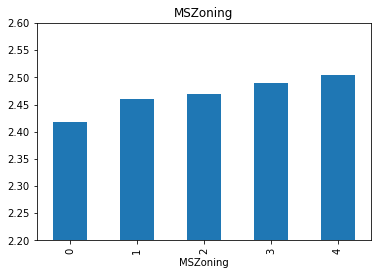

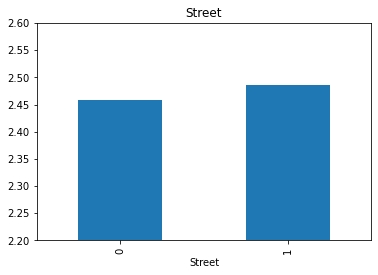

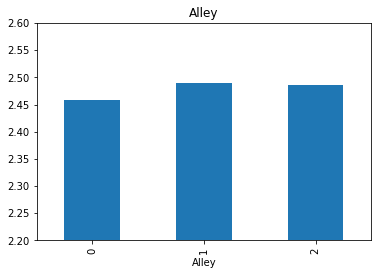

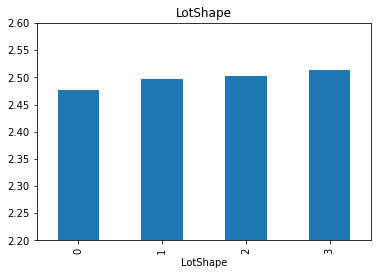

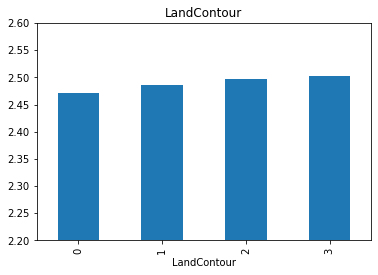

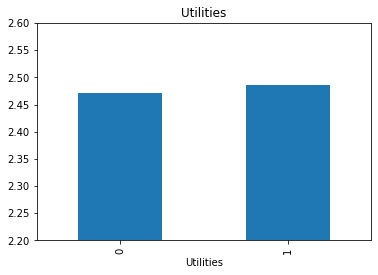

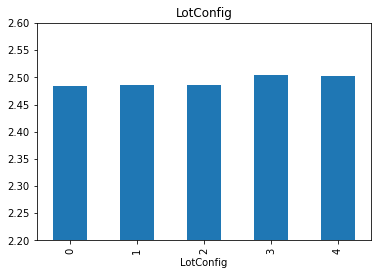

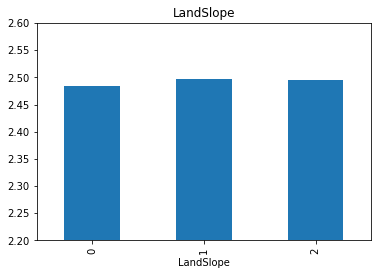

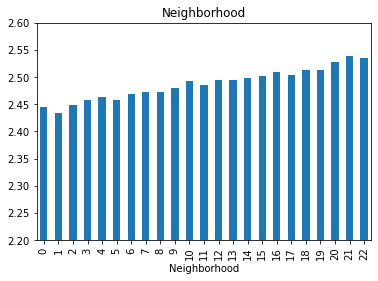

In [180]:
# let explore the monotonic relationship between the target variable 
# and label

def analyse_vars(train, y_train, var):

    tmp = pd.concat([X_train, np.log(y_train)], axis = 1)

    tmp.groupby(var)['SalePrice'].median().plot.bar()

    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.show()


for var in cat_others:
    analyse_vars(X_train, y_train, var)